# Initial analysis

In [1]:
## importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
## reading data from the file
data=pd.read_csv('Results dataset.csv')

In [3]:
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


So, after the first glance at the data, we can conclude that it comes from Titanic Kaggle competition https://www.kaggle.com/c/titanic.  

In that competition we need to predict who of Titanic's passengers are likely to survive given the set of their personal characterics and some information related to the trip itself.

The dataset contains 12 columns out of which 2 are of float64 type (continous variables, however after looking at the first five rows we spot that only **Fare** variable is a continous but **Age** is an integer one), 5 are of int64 type (integer variables) and 5 are of object type (text or other types of data).

It is a typical binary classification problem. The objective is to build a model that predicts if **Survived** for each **PassengerId**. **Survived** variable, which is a target for prediction, takes only two values 0 (died) and 1 (survived). The criterion that asserts goodness of the model is the Accuracy of prediction, i.e. percentage of passangers that the model forecasts correctly. So, the aim is to get the model with the highest possible accuracy of prediction. 


For machine learning model is of immense importance its generalization performance, especially for a business problem. This essetially means that the models needs to perform well on the unseen data. For this purpose let's divede our data set into two subsets: training and hold-out. 

In [4]:
y=data.Survived
X=data.drop(columns=['PassengerId'] )

In [5]:
from sklearn.model_selection import StratifiedShuffleSplit

sss=StratifiedShuffleSplit(n_splits=2, test_size=0.2, random_state=22)

for train_index, test_index in sss.split(X, y):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y[train_index], y[test_index]

In [6]:
X_train.shape, X_test.shape

((712, 11), (179, 11))

Therefore, after splitting the dataset we obtained 712 observation in the training subset. 

## Exploratory Data Analysis

Let's explore the dataset by different means of visualization. From below we can observe that only **Age** and **Cabin** and **Embarked** variables have missing values in them

In [7]:
X_train.isnull().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         143
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       547
Embarked      1
dtype: int64

### Target (Survived)

0    0.616573
1    0.383427
Name: Survived, dtype: float64

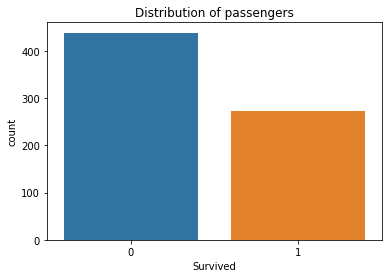

In [8]:
sns.countplot(y_train)
plt.title('Distribution of passengers')
y_train.value_counts()/X_train.shape[0]

From the graph above it's apparent that most of the passengers in training set didn't survive (62%).  

### Pclass

Pclass variable denotes a ticket class. Let's explore its distribution. 

3    0.551966
1    0.245787
2    0.202247
Name: Pclass, dtype: float64

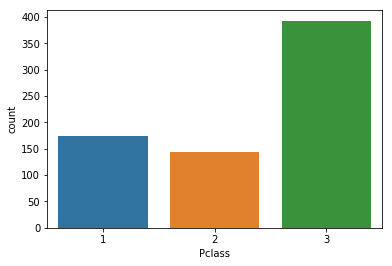

In [9]:
sns.countplot(X_train.Pclass)
X_train.Pclass.value_counts()/X_train.shape[0]

In [10]:
X_train.groupby('Pclass')['Survived'].value_counts()/X_train.shape[0]

Pclass  Survived
1       1           0.151685
        0           0.094101
2       0           0.103933
        1           0.098315
3       0           0.418539
        1           0.133427
Name: Survived, dtype: float64

More than 50% of the passengers had tickets of the third class. Value counts suggets that passengers of first class were more likely to survive. Odds of survival for the second class were almost the same. And the third class passengers were 3 time more likely to sink than to survive.

### Gender

male      0.658708
female    0.341292
Name: Sex, dtype: float64


Sex     Survived
female  1           0.252809
        0           0.088483
male    0           0.528090
        1           0.130618
Name: Survived, dtype: float64

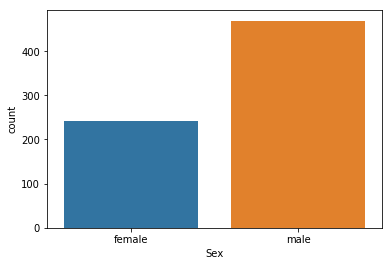

In [11]:
sns.countplot(X_train.Sex)
print( X_train.Sex.value_counts()/X_train.shape[0] )
X_train.groupby('Sex')['Survived'].value_counts()/X_train.shape[0]

66% of the passengers are Men and only 34% are women. A woman is three times more likely to survive than to die. At the same time only 20% of men survived and 80 sank. So, a gender dummy variables would be a strong predictor for a survival.   

### Age

There are 20% of missing values in **Age** column. Missingness might suggest that those passengers are significantly different from other in term of survival. Let's explore it more. 

In [12]:
X_train[ X_train.Age.isnull() ]['Survived'].value_counts()

0    101
1     42
Name: Survived, dtype: int64

Those passengers with missing **Age** were much more likely to die than to survive (odds ratio 5:2) 

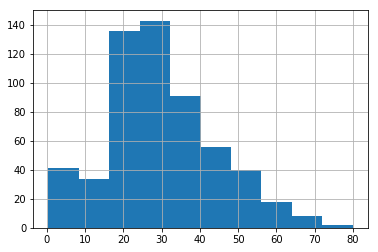

In [13]:
X_train.Age.hist()

In [18]:
med_age=X_train['Age'].median()
full_Age=X_train.fillna({'Age':med_age})['Age']

C:\Anaconda\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


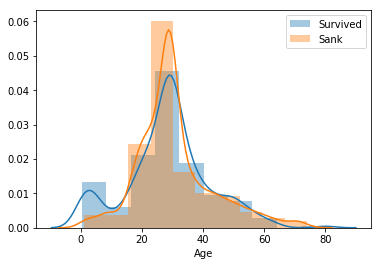

In [19]:
sns.distplot( full_Age.loc[X_train.Survived==1],bins=10, label='Survived' )
sns.distplot( full_Age.loc[X_train.Survived==0],bins=10, label='Sank' )
plt.legend()

The plot above indicates that young passenger, namely younger than 20 were more likely to survive

### SibSp

In [20]:
X_train.SibSp.value_counts()

0    489
1    164
2     22
3     15
4     12
8      6
5      4
Name: SibSp, dtype: int64

In [21]:
X_train.groupby('SibSp')['Survived'].value_counts()

SibSp  Survived
0      0           320
       1           169
1      1            88
       0            76
2      0            12
       1            10
3      0            11
       1             4
4      0            10
       1             2
5      0             4
8      0             6
Name: Survived, dtype: int64

Most of the passengers were travelling with no sibllings nor spouses (almost 70%) and they were less likely to survive. 

### Parch

In [22]:
X_train.Parch.value_counts()

0    544
1     96
2     63
5      3
3      3
4      2
6      1
Name: Parch, dtype: int64

In [23]:
X_train.groupby('Parch')['Survived'].value_counts()

Parch  Survived
0      0           354
       1           190
1      1            51
       0            45
2      0            33
       1            30
3      0             2
       1             1
4      0             2
5      0             2
       1             1
6      0             1
Name: Survived, dtype: int64

Similiar to previous conclusion can be drawn from **Parch** variable.

### Fare

In [24]:
pd.qcut( X_train.Fare, 3 ).value_counts()

(8.517, 26.0]      238
(-0.001, 8.517]    238
(26.0, 512.329]    236
Name: Fare, dtype: int64

In [25]:
X_train['Survived'].groupby(pd.qcut(X_train['Fare'],3)).mean()

Fare
(-0.001, 8.517]    0.218487
(8.517, 26.0]      0.373950
(26.0, 512.329]    0.559322
Name: Survived, dtype: float64

In [26]:
pd.crosstab(pd.qcut(X_train['Fare'],4), columns=X_train['Pclass'])

Pclass,1,2,3
Fare,,,
"(-0.001, 7.896]",5,3,174
"(7.896, 14.479]",0,64,110
"(14.479, 31.0]",43,57,79
"(31.0, 512.329]",127,20,30


This variable highly correlates with **Pclass**

### Embarked

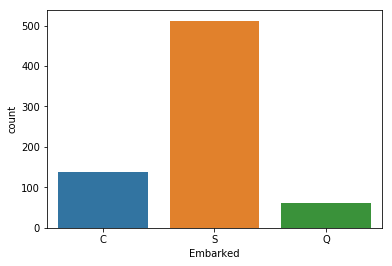

In [27]:
sns.countplot( X_train.Embarked )

In [28]:
X_train.groupby('Embarked')['Survived'].value_counts()

Embarked  Survived
C         1            69
          0            68
Q         0            37
          1            25
S         0           334
          1           178
Name: Survived, dtype: int64

Most passengers were embarked in Southampton and they were twice more likely to sink than to survive. 

## Feature Engineering

In [29]:
# This variable is an indicator than values of Age columns are missing
X_train['Missing_age']=0
X_train.loc[X_train.Age.isnull(),'Missing_age']=1


med_age=X_train['Age'].median()
X_train.fillna({'Age':med_age}, inplace=True )


## This is a dummy for young passengers
X_train['Children']=0
X_train.loc[X_train.Age<20, 'Children']=1

In [30]:
X_train['SS']=1
X_train.loc[X_train.SibSp==0,'SS']=0

X_train['PCh']=1
X_train.loc[X_train.Parch==0,'PCh']=0

In [31]:
X_train=pd.get_dummies(X_train, columns=['Sex','Embarked'],drop_first=True)

In [32]:
X_train.drop(columns=['Survived','Name','Ticket','Cabin'],inplace=True)

In [33]:
# This variable is an indicator than values of Age columns are missing
X_test['Missing_age']=0
X_test.loc[X_test.Age.isnull(),'Missing_age']=1


# med_age=X_train['Age'].median()
X_test.fillna({'Age':med_age}, inplace=True )


## This is a dummy for young passengers
X_test['Children']=0
X_test.loc[X_test.Age<20, 'Children']=1

X_test['SS']=1
X_test.loc[X_test.SibSp==0,'SS']=0

X_test['PCh']=1
X_test.loc[X_test.Parch==0,'PCh']=0

X_test=pd.get_dummies(X_test, columns=['Sex','Embarked'],drop_first=True)
X_test.drop(columns=['Survived','Name','Ticket','Cabin'],inplace=True)

## Modeling

In [76]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from lightgbm import LGBMClassifier

In [96]:
lr=LogisticRegressionCV(penalty='l1',Cs=[0.01, 0.1, 1 ],cv=3, solver='liblinear',random_state=42).fit(X_train,y_train)

print('Test set score for Logistic Regression:', lr.score(X_test, y_test) )

print('Test set score for Logistic Regression:', lr.score(X_train, y_train) )

Test set score for Logistic Regression: 0.8212290502793296
Test set score for Logistic Regression: 0.8075842696629213


**Logistic regression** produces 82% accuracy on testing dataset, which is pretty decent. 

In [97]:
rf=RandomForestClassifier(n_estimators=100, max_depth=3, random_state=42).fit(X_train,y_train)

print('Train set score for Random Forest:', rf.score(X_train,y_train) )
print('Test set score for Random Forest:', rf.score(X_test,y_test) )

Test set score for Random Forest: 0.8324022346368715
Test set score for Random Forest: 0.8328651685393258


**Random Forest Classifier** performs a little bit better but not by much

In [93]:
svc=SVC(C=1,random_state=42).fit(X_train,y_train)

print('Test set score for SVM:', svc.score(X_test,y_test) )

Test set score for SVM: 0.7094972067039106


C:\Anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


**Support Vector Classifier** with defual parameters don't perform well on this dataset

In [92]:
lgbc=LGBMClassifier(objective='binary',max_depth=5, learning_rate=.1,
                    random_state=42, n_estimators=100).fit(X_train, y_train)

print('Test set score for LGBM:', lgbc.score(X_test,y_test) )


Test set score for LGBM: 0.8379888268156425


**LightGBM** algorithm without parameter tuning performs on the same level as logistic regression and random forest. 

In [108]:
## prediction of survival on full dataset
prediction=lgbc.predict( pd.concat([X_train,X_test]) )

In [106]:
## this is a score on a full dataset for the best model. 
lgbc.score( pd.concat([X_train,X_test]).sort_index(), y) 

0.8877665544332211

## This model needs further work in order to improve accuracy of prediction by incorporation some variables that were missed. Accuracy of around 83-84% is pretty high for out-of-shelf model and basic feature engineering.  